In [60]:
import pandas
import numpy as np
from matplotlib import pyplot as plt
import seaborn

from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.model_selection import train_test_split

from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')


seaborn.set()
%matplotlib inline

# Model building
After looking at the data, it makes sense to treat each hub independent and build models for each hour of the day seperately. For this quick study, I will build a model which finds the historically most similar conditions (load forecast, weather forecast) for a given hour of the day.
To limit computations to my laptop, I will focus on the Minnesota hub and will train on 2015 data and test on the 2016 data.

## Feature extraction
To do the modelling, we need to build the feature vectors by joining the weather and load data sets.

In [2]:
df = pandas.read_excel("test_data.xlsx", sheetname=[0,1,2])
market_data = df[0]
weather_data = df[1]
load_data = df[2]

In [33]:
minn_df = market_data.loc[market_data['nodename'] == "MINN.HUB"]
minn_df = minn_df.ix[:, ["localday", "he", "rtlmp", "dalmp"] ][:]
minn_df.rename(columns={'he': 'hour', 'localday': 'datetime'}, inplace=True)

minn_df["hour"] -= 1

minn_df["datetime"] += [timedelta(hours=int(h)) for h in minn_df.hour]

In [34]:
min_date = minn_df["datetime"].min()
max_date = minn_df["datetime"].max()

In [35]:
minn_weather =  weather_data.loc[weather_data.station_name == "Minneapolis"]
minn_weather =  minn_weather.loc[(weather_data.datetime >= min_date) & (weather_data.datetime <= max_date)]
minn_weather.rename(columns={"value": "temperature"}, inplace=True)

In [36]:
merged = minn_df.merge(minn_weather, on="datetime")

In [37]:
minn_load =  load_data.loc[(load_data.localdatetime >= min_date) & (load_data.localdatetime <= max_date)] 
minn_load.rename(columns={"localdatetime": "datetime"}, inplace=True)

In [38]:
minn_load["hour"] = [h.hour for h in minn_load.datetime]

In [39]:
aligned_data = merged.merge(minn_load, on="datetime")

,datetime,hour_x,rtlmp,dalmp,station_name,hour_y,temperature,north_mtlf,north_actual_load,central_mtlf,central_actual_load,south_mtlf,south_actual_load,miso_mtlf,miso_actual_load,Unnamed: 9,Unnamed: 10,Unnamed: 11,hour
1,2015-01-01 01:00:00,1,13.02,18.35,Minneapolis,1,-12,17160,16916.96,39138,39471.60,19013,18887.39,75311,75275.95,NaN,NaN,NaN,1
25,2015-01-02 01:00:00,1,22.02,23.33,Minneapolis,1,-12,16050,16052.03,38604,36109.29,18163,17395.15,72817,69556.47,NaN,NaN,NaN,1
49,2015-01-03 01:00:00,1,18.30,17.49,Minneapolis,1,-4,15940,15899.24,36704,36669.73,16693,16202.18,69337,68771.15,NaN,NaN,NaN,1
73,2015-01-04 01:00:00,1,15.42,12.66,Minneapolis,1,-13,16604,17077.17,36675,34619.94,16043,16040.22,69322,67737.33,NaN,NaN,NaN,1
97,2015-01-05 01:00:00,1,22.54,23.25,Minneapolis,1,-22,18275,18092.70,41662,41491.08,18797,19245.74,78734,78829.52,NaN,NaN,NaN,1
121,2015-01-06 01:00:00,1,28.39,25.44,Minneapolis,1,-19,18760,18556.19,43507,43652.88,20959,21307.62,83226,83516.69,NaN,NaN,NaN,1
145,2015-01-07 01:00:00,1,17.81,20.70,Minneapolis,1,-19,19121,19246.73,45534,44441.17,19696,19331.26,84351,83019.16,NaN,NaN,NaN,1
169,2015-01-08 01:00:00,1,35.70,23.47,Minneapolis,1,-21,19658,19444.18,48903,48576.26,23517,24828.67,92078,92849.11,NaN,NaN,NaN,1
193,2015-01-09 01:00:00,1,21.05,15.84,Minneapolis,1,-17,19080,18936.37,47409,45424.46,23664,23185.96,90153,87546.79,NaN,NaN,NaN,1
217,2015-01-10 01:00:00,1,27.19,24.70,Minneapolis,1,-18,18678,18540.70,45988,45932.65,23072,22841.27,87738,87314.62,NaN,NaN,NaN,1


In [118]:
predicted = []
truth = []
scores = []
for hour in range(24):
    
    X = aligned_data.loc[aligned_data.hour == hour].ix[:, ["temperature", "north_mtlf", "dalmp"]].as_matrix()
    y = aligned_data.loc[aligned_data.hour == hour].rtlmp

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=250, random_state=42)
    
    model = KNN(n_neighbors=40)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    score = model.score(X_test, y_test)
    
    predicted.append(predictions)
    truth.append(y_test)
    
predicted = np.vstack(predicted)
truth = np.vstack(truth)

In [119]:
error = np.linalg.norm(truth-predicted, ord=2, axis=0)
best_pred = np.argsort(error)[:20]

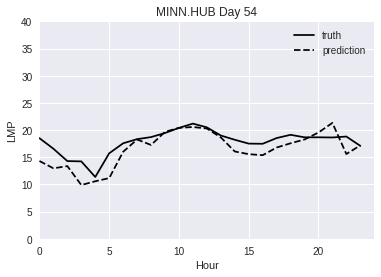

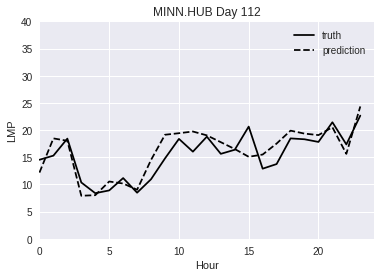

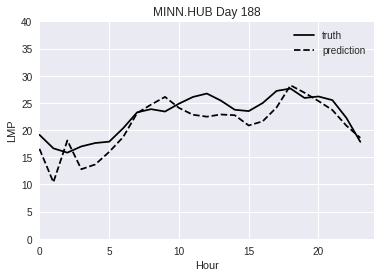

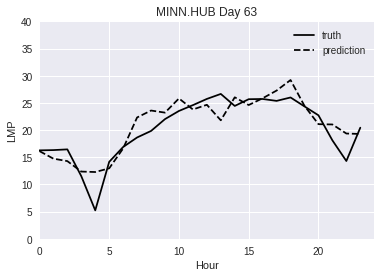

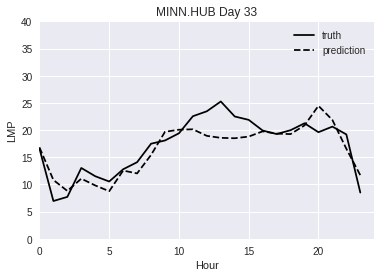

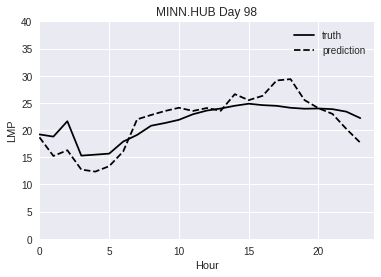

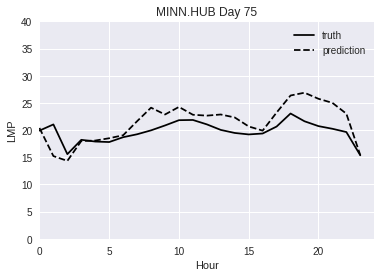

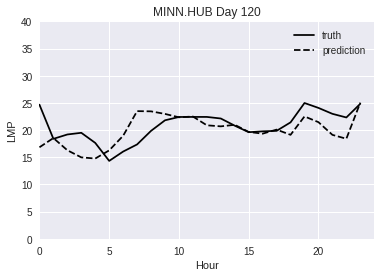

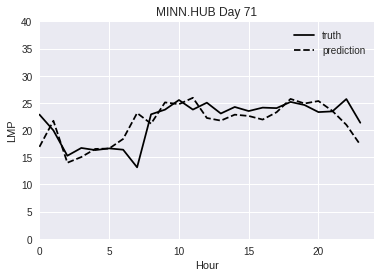

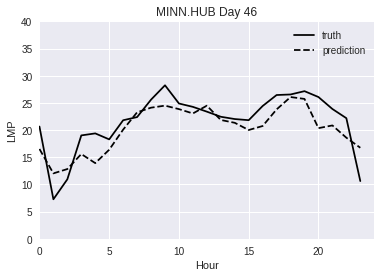

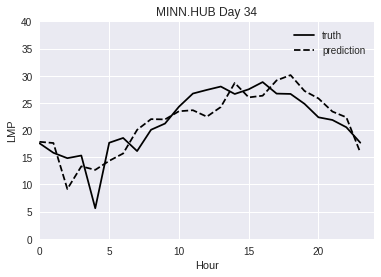

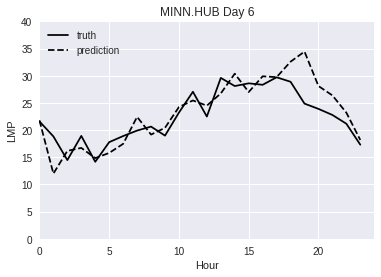

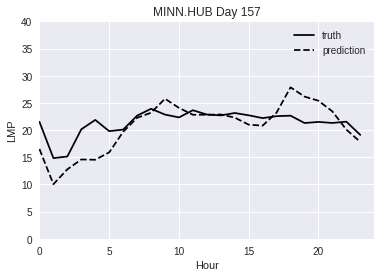

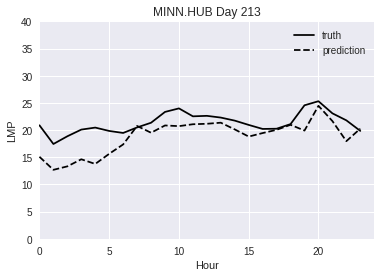

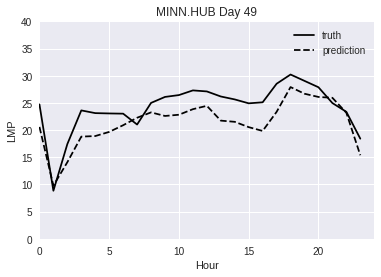

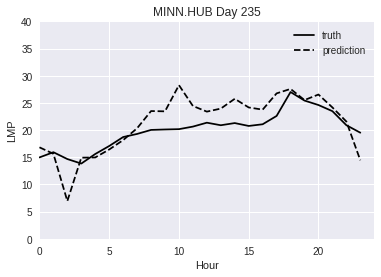

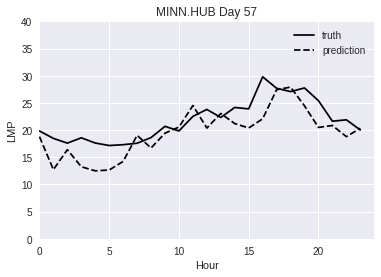

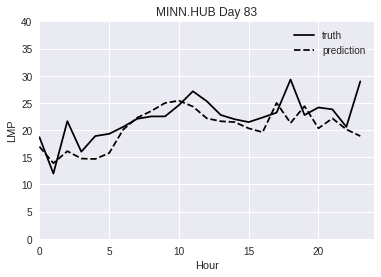

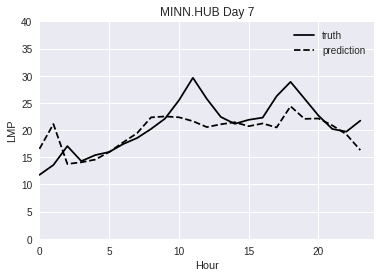

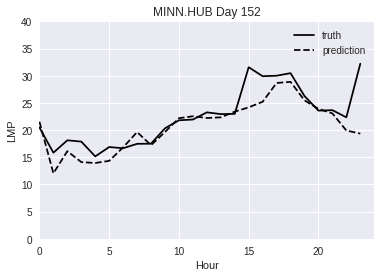

In [127]:
for i in best_pred:
    plt.figure()
    plt.plot(truth[:,i], 'k-', label="truth")
    plt.plot(predicted[:,i], 'k--', label="prediction")

    
    plt.ylabel("LMP")
    plt.ylim(0,40)
    plt.xlim(0,24)
    plt.xlabel("Hour")
    plt.title("MINN.HUB Day {0}".format(i))
    
    plt.legend()
    
    plt.savefig("example_{0}".format(i))